In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

Loading in the Texas school districts map, and DISTGRAD dataset.

In [5]:
geo = r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\2.1Geometry\cb_2018_us_county_20m.zip"
geo_tx = gpd.read_file(geo)
grad_2023_name = r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distgrad_2023_clean.csv"
distgrad = pd.read_csv(grad_2023_name)

A 70% threshold was chosen. I thought it was best to set a higher threshold because the data in this dataset is not used for clustering. So, districts that use this outcome data to compare afterwards should be able to use it if those certain features are available for them.

Even with such a high threshold, there were a lot of columns that were cut, especially for certain minority groups that may be so small that there isn't enough data in certain districts. This includes nearly all data related to RHSP, which was the old graduation program followed by Texas schools. However, the Texas Education Agency has moved on to a new program some years ago, called FHSP, so there no longer should be students in the RHSP program.

In [6]:
threshold = 0.7  # 70% threshold
na_percent = distgrad.isna().mean()
columns_to_remove = na_percent[na_percent >= threshold].index

distgrad_cleaned = distgrad.drop(columns=columns_to_remove)

print("Removed columns (70% or more NAs):")
print(columns_to_remove.tolist())

Removed columns (70% or more NAs):
['District 2022 Attendance: Pacific Islander Days Present', 'District 2022 Attendance: American Indian Days Present', 'District 2022 Attendance: Pacific Islander Days Membership', 'District 2022 Attendance: American Indian Days Membership', 'District 2022 Attendance: Pacific Islander Rate', 'District 2022 Attendance: American Indian Rate', 'District 2021 Attendance: Pacific Islander Days Present', 'District 2021 Attendance: American Indian Days Present', 'District 2021 Attendance: Pacific Islander Days Membership', 'District 2021 Attendance: American Indian Days Membership', 'District 2021 Attendance: Pacific Islander Rate', 'District 2021 Attendance: American Indian Rate', '2022 district Chronic Absenteeism American Indian Group: Numerator', '2022 district Chronic Absenteeism American Indian Group: Denominator', '2022 district Chronic Absenteeism Pacific Islander Group: Numerator', '2022 district Chronic Absenteeism Pacific Islander Group: Denominato

Next, we merge the dataset with the map. There are a lot less districts counted in the map than there are in the dataset. This is because the dataset includes charter schools, which we have found through previous EDA greatly skews the data. So, by only including districts in the dataset that match with districts recognized in the map, we can remove all the extraneous charter schools.

In [7]:
# Remove leading apostrophe in 'DISTRICT_id' for DISTGRAD
distgrad_cleaned["DISTRICT_id"] = distgrad_cleaned["DISTRICT_id"].astype(str).str.lstrip("'")

distgrad_cleaned = distgrad_cleaned.rename(columns={"DISTRICT_id": "District_ID"})
geo_tx = geo_tx.rename(columns={"DISTRICT_C": "District_ID"})

# Convert District_ID to integer
distgrad_cleaned["District_ID"] = pd.to_numeric(distgrad_cleaned["District_ID"], errors="coerce")
geo_tx["District_ID"] = pd.to_numeric(geo_tx["District_ID"], errors="coerce")

# Remove charter schools and any other extraneous districts
distgrad_filtered = distgrad_cleaned[distgrad_cleaned["District_ID"].isin(geo_tx["District_ID"])]

# Merge
merged_data = geo_tx.merge(distgrad_filtered, on="District_ID", how="left")
merged_data = gpd.GeoDataFrame(merged_data)

KeyError: 'District_ID'

Next are a few map plots just to see a few outcome features across the state. I took a look at some disadvantaged groups – economically disadvantaged students, Black students, and at-risk students – across different features, such as graduation rates and attendance.

A student counts towards chronic absenteeism if they miss more than 10% of school days in a year.

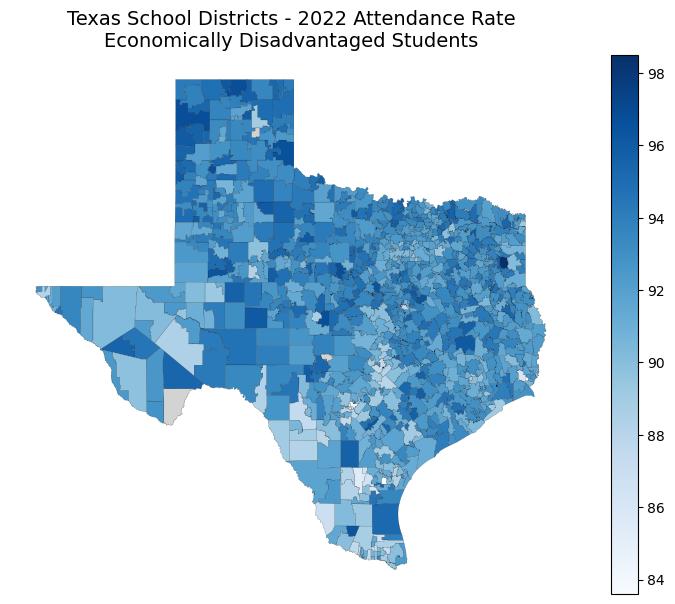

In [ ]:
variable_to_plot = "District 2022 Attendance: Econ Disadv Rate"

fig, ax = plt.subplots(figsize=(10, 7))
merged_data.plot(column=variable_to_plot, cmap="Blues", linewidth=0.1, edgecolor="black",
                 legend=True, missing_kwds={"color": "lightgrey"}, ax=ax)

ax.set_title("Texas School Districts - 2022 Attendance Rate\nEconomically Disadvantaged Students", fontsize=14)
ax.set_axis_off()

plt.show()

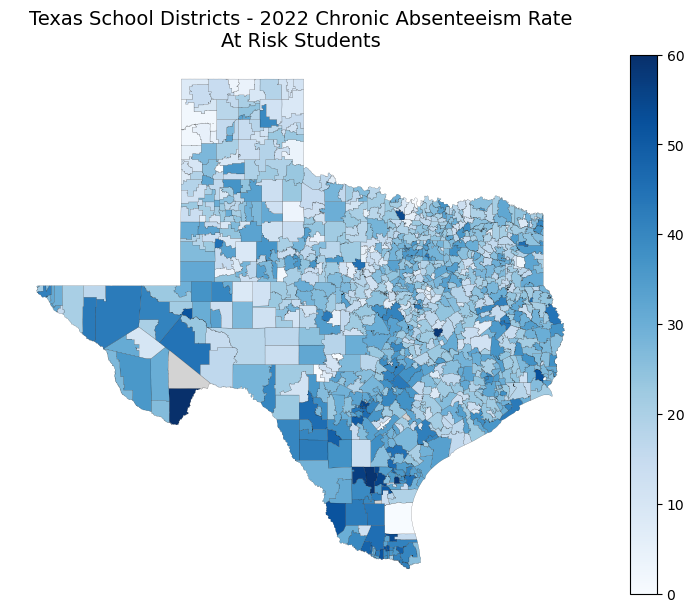

In [ ]:
variable_to_plot = "2022 district Chronic Absenteeism At Risk Group: Rate"

fig, ax = plt.subplots(figsize=(10, 7))
merged_data.plot(column=variable_to_plot, cmap="Blues", linewidth=0.1, edgecolor="black",
                 legend=True, missing_kwds={"color": "lightgrey"}, ax=ax)

ax.set_title("Texas School Districts - 2022 Chronic Absenteeism Rate\nAt Risk Students", fontsize=14)
ax.set_axis_off()

plt.show()

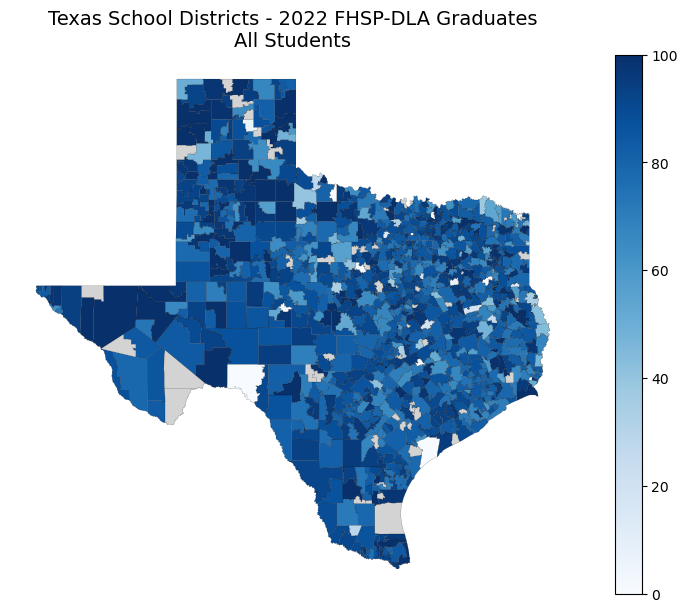

In [ ]:
variable_to_plot = "District 2022 Graduates: FHSP-DLA All Students %"

fig, ax = plt.subplots(figsize=(10, 7))
merged_data.plot(column=variable_to_plot, cmap="Blues", linewidth=0.1, edgecolor="black",
                 legend=True, missing_kwds={"color": "lightgrey"}, ax=ax)

ax.set_title("Texas School Districts - 2022 FHSP-DLA Graduates\nAll Students", fontsize=14)
ax.set_axis_off()

plt.show()

Taking a look at top 10 districts in dropout rates and chronic absenteeism rates. This will be good to know after looking at DISTPROF, which contains data on demographic features.

/var/folders/by/yfr7y_td119bsx4d_c8r0sr40000gn/T/ipykernel_82426/4006727052.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_districts, x=dropout_col, y="NAME", palette="Blues_r")


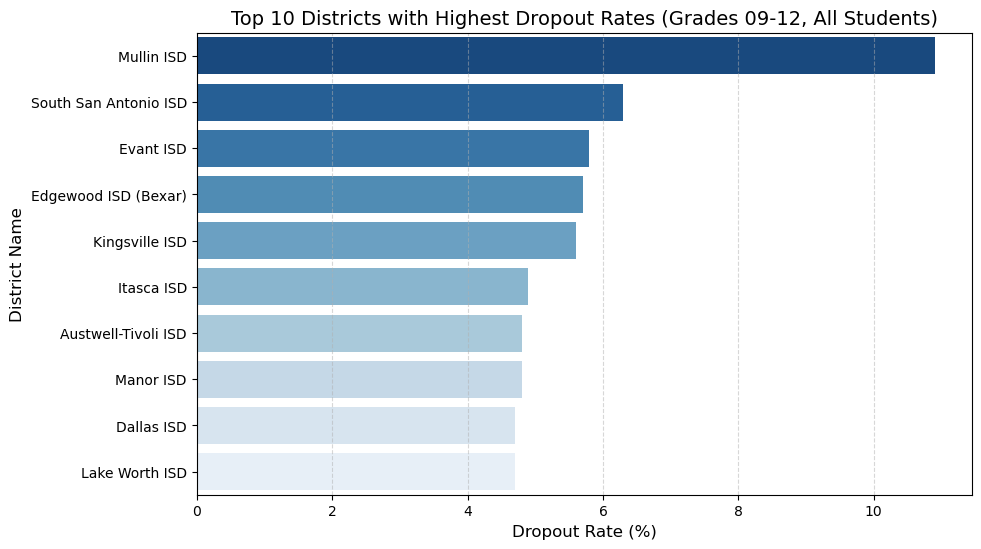

In [ ]:
import seaborn as sns
# Define the column name for dropout rates
dropout_col = "District 2022 Annual Dropout for Grades 09-12: All Students Rate"

# # Drop rows where dropout rate is NaN
# distgrad_filtered = distgrad.dropna(subset=[dropout_col])

# Select the top 10 districts with highest dropout rates
top_10_districts = merged_data.nlargest(10, dropout_col)[["District_ID", "NAME", dropout_col]]

# Sort for better visualization
top_10_districts = top_10_districts.sort_values(by=dropout_col, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_districts, x=dropout_col, y="NAME", palette="Blues_r")

# Labels and title
plt.xlabel("Dropout Rate (%)", fontsize=12)
plt.ylabel("District Name", fontsize=12)
plt.title("Top 10 Districts with Highest Dropout Rates (Grades 09-12, All Students)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Show the plot
plt.show()

/var/folders/by/yfr7y_td119bsx4d_c8r0sr40000gn/T/ipykernel_82426/935438289.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_districts, x=absentee_col, y="NAME", palette="Blues_r")


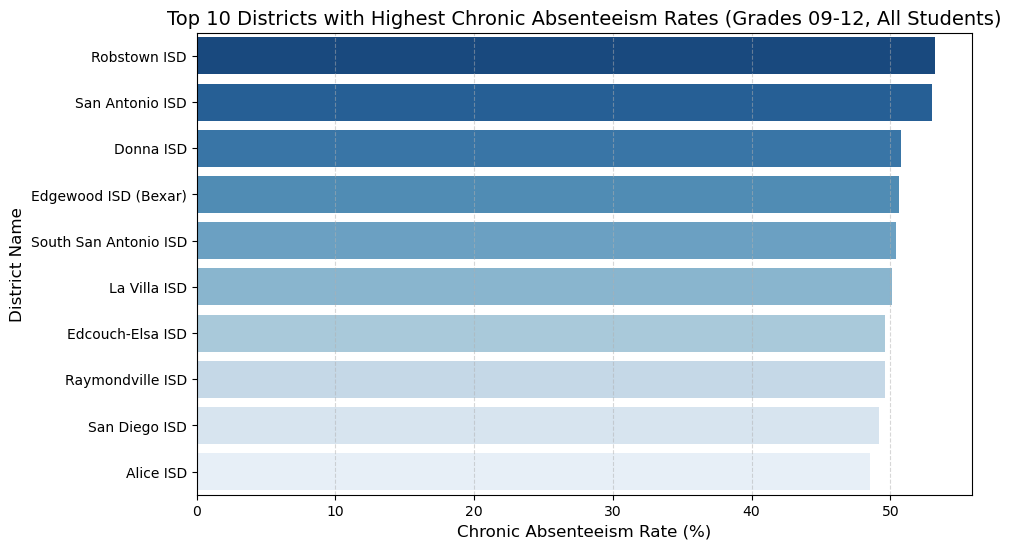

In [ ]:
# Define the column name for dropout rates
absentee_col = "2022 district Chronic Absenteeism All Students Group: Rate"

# # Drop rows where dropout rate is NaN
# distgrad_filtered = distgrad.dropna(subset=[dropout_col])

# Select the top 10 districts with highest dropout rates
top_10_districts = merged_data.nlargest(10, absentee_col)[["District_ID", "NAME", absentee_col]]

# Sort for better visualization
top_10_districts = top_10_districts.sort_values(by=absentee_col, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_districts, x=absentee_col, y="NAME", palette="Blues_r")

# Labels and title
plt.xlabel("Chronic Absenteeism Rate (%)", fontsize=12)
plt.ylabel("District Name", fontsize=12)
plt.title("Top 10 Districts with Highest Chronic Absenteeism Rates (Grades 09-12, All Students)", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Show the plot
plt.show()

In [ ]:
# used this just to check correct names of columns
for col in merged_data.columns:
    if col.startswith("2022 district Chronic Absenteeism"):
        print(col)

2022 district Chronic Absenteeism All Students Group: Numerator
2022 district Chronic Absenteeism All Students Group: Denominator
2022 district Chronic Absenteeism African American Group: Numerator
2022 district Chronic Absenteeism African American Group: Denominator
2022 district Chronic Absenteeism Hispanic Group: Numerator
2022 district Chronic Absenteeism Hispanic Group: Denominator
2022 district Chronic Absenteeism White Group: Numerator
2022 district Chronic Absenteeism White Group: Denominator
2022 district Chronic Absenteeism Asian Group: Numerator
2022 district Chronic Absenteeism Asian Group: Denominator
2022 district Chronic Absenteeism Two or More Races Group: Numerator
2022 district Chronic Absenteeism Two or More Races Group: Denominator
2022 district Chronic Absenteeism Econ Disadv Group: Numerator
2022 district Chronic Absenteeism Econ Disadv Group: Denominator
2022 district Chronic Absenteeism Special Ed Group: Numerator
2022 district Chronic Absenteeism Special Ed Gro

I wanted to see how chronic absenteeism and dropout rate were for at-risk studnets specifically, when compared to the numbers for all students. In the graph, we can see that there are 10+ districts with chronic absenteeism rates above 60%. However, many of those schools don't have excessive dropout rates.

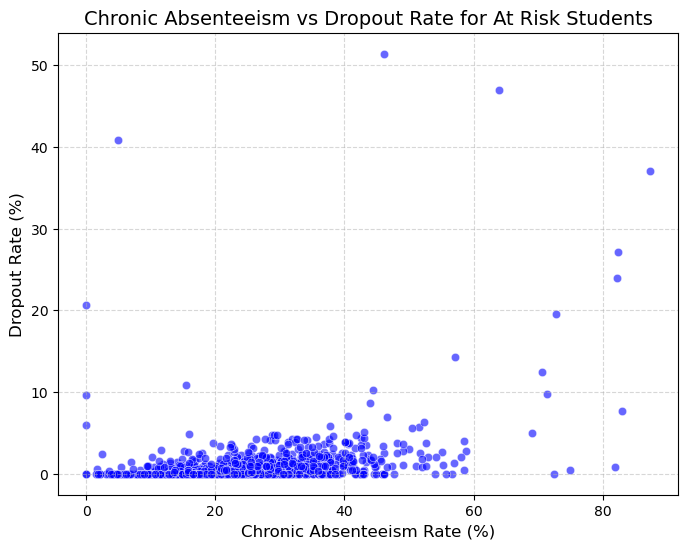

In [ ]:
absenteeism_col = "2022 district Chronic Absenteeism At Risk Group: Rate"

plt.figure(figsize=(8, 6))
sns.scatterplot(data=distgrad_filtered, x=absenteeism_col, y=dropout_col, alpha=0.6, color="blue")

plt.xlabel("Chronic Absenteeism Rate (%)", fontsize=12)
plt.ylabel("Dropout Rate (%)", fontsize=12)
plt.title("Chronic Absenteeism vs Dropout Rate for At Risk Students", fontsize=14)

plt.grid(linestyle="--", alpha=0.5)
plt.show()
